In [55]:
import torch
from torch import nn
from torch.utils.data import Dataset
import os
from source.data_processing.image_reading import read_image
from source.data_processing.transformations import sample_random_affine_matrix
from typing import Tuple, List
from torchvision import transforms
from kornia.geometry.transform import warp_affine
from matplotlib import pyplot as plt
from source.visualization.image_visualization import plot_images_with_matches_via_mapping, plot_images_with_matches_via_match_matrix
from source.data_processing.keypoints import generate_image_grid_coordinates
from source.data_processing.transformations import *
from source.visualization.image_visualization import plot_image_with_crop

In [56]:
# class BrainDataset(Dataset):
#     def __init__(
#         self,
#         images_directory: str,
#         train: bool,
#         transform: transforms.transforms.Compose,
#     ) -> None:
#         super().__init__()
#         self.train = train
#         self.image_names = self._get_image_names(images_directory=images_directory)
#         self.images_directory = images_directory
#         self.transform = transform

#     def __len__(self) -> int:
#         """
#         Return the number of images in the dataset -1, since this dataset works with pairs of images.
#         """
#         return len(self.image_names[:-1])

#     def _get_image_names(self, images_directory: str) -> List[str]:
#         """
#         Load image names from the directory based on training or testing phase.

#         Args:
#             images_directory (str): Directory path containing images.

#         Returns:
#             List[str]: A list of image file names.
#         """
#         image_files = os.listdir(images_directory)
#         return image_files[:-2] if self.train else image_files[-2:]

#     def _get_images(self, index: int) -> Tuple[torch.Tensor, torch.Tensor]:
#         """
#         Load a pair of images from the dataset.

#         Args:
#             index (int): Index of the pair of images.

#         Returns:
#             Tuple[torch.Tensor, torch.Tensor]: A tuple containing the images.
#         """
#         image_1 = read_image(
#             os.path.join(self.images_directory, self.image_names[index])
#         )
#         image_2 = read_image(
#             os.path.join(self.images_directory, self.image_names[index + 1])
#         )

#         image_1 = transforms.ToTensor()(image_1)
#         image_2 = transforms.ToTensor()(image_2)

#         return image_1, image_2

#     def __getitem__(self, index: int):
#         # Read whole image
#         image_1, image_2 = self._get_images(index=index)

#         if self.transform:
#             image_1 = self.transform(image_1)
#             image_2 = self.transform(image_2)

#         transformation_matrix = sample_random_affine_matrix(
#             self.transformation_threshold
#         ).to(self.device)
#         image_2_transformed = warp_affine(image_2, transformation_matrix)

In [57]:
images_directory = "data/cyto_downscaled_3344_3904/"
image_names = os.listdir(images_directory)
image_1, image_2 = read_image(
    os.path.join(images_directory, image_names[0])
), read_image(os.path.join(images_directory, image_names[1]))
image_1 = transforms.ToTensor()(image_1)
image_2 = transforms.ToTensor()(image_2)

In [58]:
image_size = image_1.shape[-2:]

In [59]:
transformation_matrix = sample_random_affine_matrix(range_limit=0.3)
image_2 = warp_affine(
    src=image_2.unsqueeze(0), M=transformation_matrix, dsize=image_size, mode="nearest"
)[0]

In [60]:
grid_coordinates = generate_image_grid_coordinates(image_size)

In [61]:
image_coordinate_mapping = transform_grid_coordinates(
    grid_coordinates, transformation_matrix[0]
)

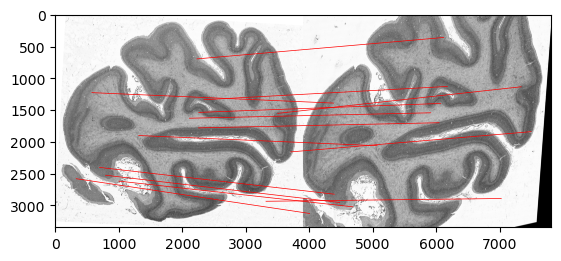

In [62]:
plot_images_with_matches_via_mapping(
    image_1,
    image_2,
    image_coordinate_mapping,
    number_of_matches=20,
    sample_keypoints_randomly=True,
)

In [63]:
from source.data_processing.cropping import sample_crop_coordinates, crop_image

In [64]:
crop_size = 640
max_translation_shift = 50

crop_position_image_1, crop_position_image_2 = sample_crop_coordinates(
    coordinate_mapping=image_coordinate_mapping,
    crop_size=crop_size,
    max_translation_shift=max_translation_shift,
)

In [65]:
crop_position_image_2

tensor([576, 784])

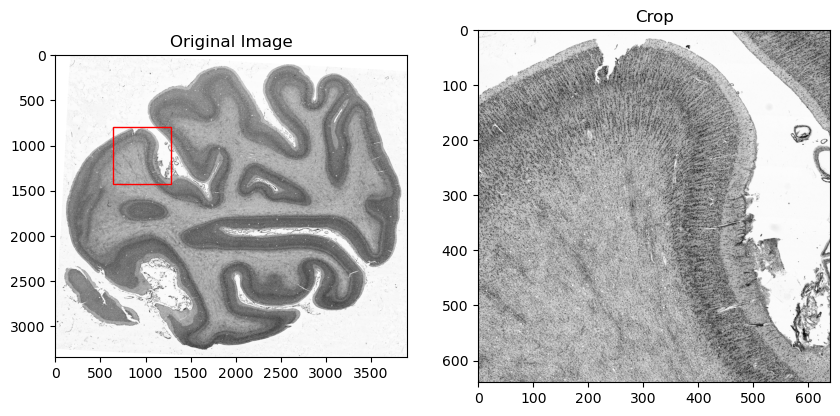

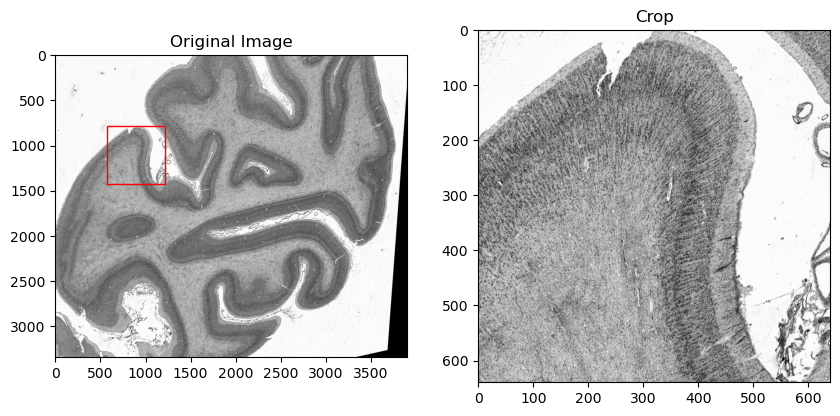

In [66]:
image_1_crop = crop_image(
    image=image_1, crop_position=crop_position_image_1, crop_size=crop_size
)
image_2_crop = crop_image(
    image=image_2, crop_position=crop_position_image_2, crop_size=crop_size
)
plot_image_with_crop(
    original_image=image_1, crop_image=image_1_crop, crop_position=crop_position_image_1
)
plot_image_with_crop(
    original_image=image_2, crop_image=image_2_crop, crop_position=crop_position_image_2
)

In [67]:
from source.data_processing.cropping import create_crop_coordinate_mapping

crop_coordinate_mapping = create_crop_coordinate_mapping(
    image_coordinate_mapping=image_coordinate_mapping,
    crop_position_image_1=crop_position_image_1,
    crop_position_image_2=crop_position_image_2,
    crop_size=crop_size,
)

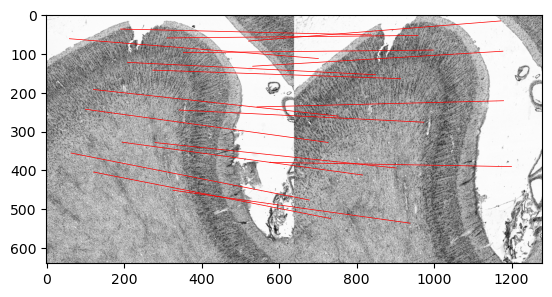

In [68]:
plot_images_with_matches_via_mapping(
    image_1_crop,
    image_2_crop,
    crop_coordinate_mapping,
    number_of_matches=20,
    sample_keypoints_randomly=True,
)

In [69]:
from source.data_processing.patch_processing import create_match_matrix

In [70]:
match_matrix = create_match_matrix(crop_coordinate_mapping, crop_size=640, patch_size=16)

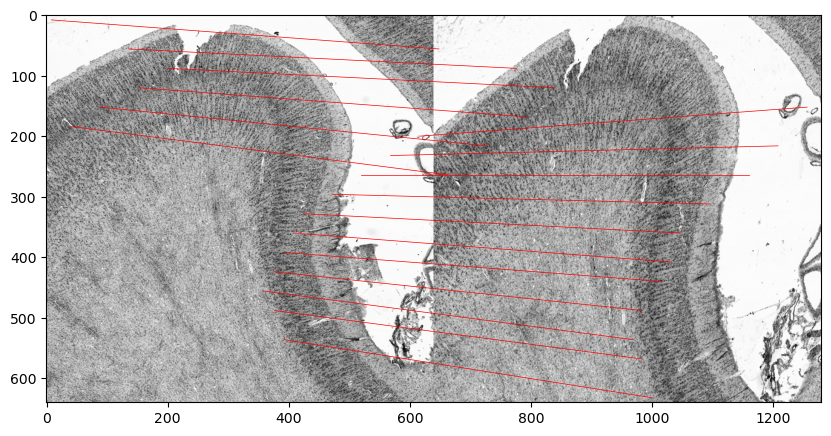

In [71]:
plot_images_with_matches_via_match_matrix(image_1_crop, image_2_crop, match_matrix, "lines")

In [72]:
def translate_coarse_to_fine(coarse_coords: torch.Tensor, coarse_size: int, fine_size: int) -> torch.Tensor:
    """
    Translates coordinates from a coarse feature map to a fine feature map.

    Args:
        coarse_coords (torch.Tensor): A tensor of shape (N, 2) representing coordinates in the coarse map.
        coarse_size (int): The size (height/width assuming square) of the coarse feature map.
        fine_size (int): The size (height/width assuming square) of the fine feature map.

    Returns:
        torch.Tensor: Translated coordinates in the fine feature map.
    """

    scale_factor = fine_size / coarse_size
    fine_coords = coarse_coords.float() * scale_factor

    return fine_coords.long()

In [73]:
translate_coarse_to_fine(torch.Tensor([[16,32]]), coarse_size=40, fine_size=160)

tensor([[ 64, 128]])

In [74]:
translate_coarse_to_fine(torch.Tensor([[68,132]]), coarse_size=160, fine_size=640)

tensor([[272, 528]])

In [75]:
from kornia.geometry.subpix import dsnt

In [76]:
dsnt.spatial_expectation2d(torch.Tensor([[[[0,0,0,0,0],
                                           [0,0,0,0,0],
                                           [0,0,1,0,0],
                                           [0,0,0,0,0],
                                           [0,0,0,0,0]]]]))

tensor([[[0., 0.]]])

In [77]:
torch.Tensor([[[[0,0,0,0,0],
                                           [0,0,0,0,0],
                                           [0,0,1,0,0],
                                           [0,0,0,0,0],
                                           [0,0,0,0,0]]]])

tensor([[[[0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0.],
          [0., 0., 1., 0., 0.],
          [0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0.]]]])

In [78]:
def translate_fine_to_coarse(fine_coords: torch.Tensor, fine_size: int, coarse_size: int) -> torch.Tensor:
    """
    Translates coordinates from a fine feature map to a coarse feature map.

    Args:
        fine_coords (torch.Tensor): A tensor of shape (N, 2) representing coordinates in the fine map.
        fine_size (int): The size (height/width assuming square) of the fine feature map.
        coarse_size (int): The size (height/width assuming square) of the coarse feature map.

    Returns:
        torch.Tensor: Translated coordinates in the coarse feature map.
    """

    scale_factor = fine_size / coarse_size
    coarse_coords = fine_coords.float() / scale_factor

    return coarse_coords.long()

In [79]:
translate_fine_to_coarse(torch.Tensor([11,11]), 640, 160)

tensor([2, 2])

Example for refinement supervision:

In [80]:
from source.data_processing.patch_processing import get_patch_index

In [87]:
get_patch_index(torch.Tensor([[0.,   120.]]))

tensor([280.])

In [82]:
def get_patch_coordinates(patch_indices: torch.Tensor, patch_size: int = 16, num_patches_per_side: int = 40) -> torch.Tensor:
    """
    Calculates the top-left coordinates of patches in the image grid from their flattened grid indices.

    Args:
        patch_indices (torch.Tensor): A tensor containing the indices of patches in the flattened grid. Shape: (N,).
        patch_size (int): The size of each square patch.
        num_patches_per_side (int): The number of patches per side of the image grid. Defaults to 40.

    Returns:
        torch.Tensor: The top-left coordinates of the patches corresponding to the given indices. Shape: (N, 2).
    """

    # Calculate x and y coordinates
    x_coords = (patch_indices % num_patches_per_side) * patch_size
    y_coords = (patch_indices // num_patches_per_side) * patch_size

    # Combine x and y coordinates
    coordinates = torch.stack((x_coords, y_coords), dim=1)

    return coordinates

In [106]:
patch_index_crop_1, patch_index_crop_2 = match_matrix.nonzero()[123]  # Some random nonzero element

In [109]:
patch_index_crop_1

tensor(183)

In [111]:
get_patch_coordinates(patch_index_crop_1.unsqueeze(0))  # Top left corner of chosen patch in crop 1

tensor([[368,  64]])

In [125]:
chosen_pixel_crop_1 = get_patch_coordinates(patch_index_crop_1.unsqueeze(0))+torch.Tensor([[8,8]]).long()  # The mid point of the patch
chosen_pixel_crop_1  # x,y

tensor([[376,  72]])

In [126]:
chosen_pixel_crop_2 = crop_coordinate_mapping[chosen_pixel_crop_1[0, 1], chosen_pixel_crop_1[0, 0]]  # Where chosen pixel is in transformed crop
chosen_pixel_crop_2

tensor([383.9958,  54.2914])

In [128]:
# Double check if the patch index is correct (we know from patch_index_crop_2)
get_patch_index(coordinates=chosen_pixel_crop_2.unsqueeze(0), patch_size=16, num_patches_per_side=40) == patch_index_crop_2

tensor([True])

In [131]:
chosen_pixel_crop_2_fine = translate_fine_to_coarse(chosen_pixel_crop_2, coarse_size=160, fine_size=640)  # Fine level feature position in transformed crop
chosen_pixel_crop_2_fine

tensor([95, 13])

In [134]:
# Double check if we can reproduce pixel in orginal crop from chosen_pixel_crop_2_fine
translate_coarse_to_fine(chosen_pixel_crop_2_fine, coarse_size=160, fine_size=640), chosen_pixel_crop_2

(tensor([380,  52]), tensor([383.9958,  54.2914]))

At this point it is clear how to get a fine feature of a patch matched in match matrix.
The next steps:

- Given the index of a matched patch in crop_1: Translate the mid pixel of this patch to fine-feature coordinates
- Do the same for crop_2
    - --> This gives the mid points of the local window for the refinement step

- For Supervision: 
    - Take the mid pixel of the patch in crop_1 and find out where it was transformed using the mapping
    - This returns coordinates in crop_2
    - Translate this coordinates to fine-features. This is different to the mid of the local window we computed before
    - Compute the relative coordinate of this fine feature wrt the local window. Note that the we already computed the mid point of this local window